# **Initial**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader  # Load the data
from torch.utils.tensorboard import SummaryWriter  # Show the Tensorboard
import cv2
import os
from matplotlib import pyplot as plt
from glob import glob
import random
import numpy as np
from math import ceil

In [3]:
print(torch.cuda.is_available())

True


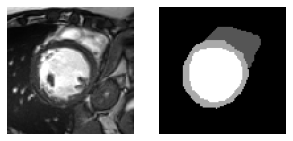

True

In [4]:
def show_image_mask(img, mask, cmap='gray'):  # visualisation
    fig = plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
data_dir = '/content/drive/My Drive/data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

# **1 DataImport**

In [5]:
################################################################################
class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root, 'mask', basename[:-4] + '_mask.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)


class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)
################################################################################

# **2 CNN Structure**

In [12]:
################################################################################
#Define a Segmentation Model
class EncoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(EncoderLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class DecoderLayer(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(DecoderLayer, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = EncoderLayer(1, 64)
        self.enc2 = EncoderLayer(64, 128)
        self.enc3 = EncoderLayer(128, 256)
        self.enc4 = EncoderLayer(256, 512, dropout=True)
        self.center = DecoderLayer(512, 1024, 512)
        self.dec4 = DecoderLayer(1024, 512, 256)
        self.dec3 = DecoderLayer(512, 256, 128)
        self.dec2 = DecoderLayer(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear',align_corners=True)], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear',align_corners=True)
################################################################################

# **4 Functions of Training, Validation**

## Parameter Setting

In [13]:
# Network Established 
net = UNet(num_classes = 4).cuda()


# The Hyperparameter that Optimized
batchsize=4
learningrate=1e-5



# Using decreaseing learning rate tuning
from torch.optim.lr_scheduler import ReduceLROnPlateau
min_learningrate=1e-12
lr_patience=10


# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learningrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
best_val_loss = 0.2

#RMSprop(net.parameters(), lr=learningrate, weight_decay=1e-8, momentum=0.9)




# Data Load
train_data_path = '/content/drive/My Drive/data/train'
train_set = TrainDataset(train_data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=batchsize, shuffle=True)
valid_data_path = '/content/drive/My Drive/data/val'
valid_set = TrainDataset(valid_data_path)
valid_data_loader = DataLoader(dataset=valid_set, num_workers=4, batch_size=batchsize, shuffle=False)

model_data_path = '/content/drive/My Drive/data/model'

writer_path = os.path.join(model_data_path,'Unet_align/log')
# Record training process ( basically for ploting figure )
writer = SummaryWriter(writer_path)

## AverageMeter and Validation Func

In [14]:
# Calculate average value of current batch
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


####
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask.cpu().numpy()].cpu().numpy().astype(int)+
        label_pred[mask.cpu().numpy()], 
        minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

###
def evaluate(predictions, gts, num_classes):
    hist = np.zeros((num_classes, num_classes))
    for lp, lt in zip(predictions, gts):
        hist += _fast_hist(lp.flatten(), lt.flatten(), num_classes)
    # axis 0: gt, axis 1: prediction
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

## Training Sec

In [15]:
def train(training_data_loader, net, loss_function, optimizer,epoch):
  # Change model status as Training Mode
    net.train()
    train_loss = AverageMeter()
    curr_iter = (epoch - 1) * len(training_data_loader)
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        img=img.unsqueeze(1).cuda() # adding 1 channel
        mask=mask.cuda()

        N = img.size(0)           # number of batch
        optimizer.zero_grad()     # CLEAR GRADIENT BUFFER
        outputs = net(img)        # FORWARD
        loss = loss_function(outputs, mask.to(dtype=torch.int64)) / N # mask type need to be long
        loss.backward()           # BACKWORD
        optimizer.step()          # UPDATE GRADIENT

        train_loss.update(loss.data.item(),N) # Average loss of this loop
        curr_iter += 1
        writer.add_scalar('train_loss', train_loss.avg, curr_iter)

        if (iteration + 1) % 10 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (
                  epoch+1, iteration + 1, len(training_data_loader), train_loss.avg
        ))
    return train_loss.avg

## Validation sec

In [16]:
def validation(valid_data_loader, net, loss_function, optimizer, epoch):
    # Model Status as Evaluation Mode
    net.eval()
    val_loss = AverageMeter()
    img_all, mask_all, predictions_all = [], [], []

    for iteration, sample in enumerate(valid_data_loader): 
        img, mask = sample
        img=img.unsqueeze(1).cuda() # adding 1 channel
        mask=mask.to(dtype=torch.int64).cuda()# mask should be long type

        N = img.size(0)           # number of data
        outputs = net(img)        # FORWARD
        # Take max over 1D, return [[max of each row], [index of each max]]
        # Get the Max values index
        predictions = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy() 

        val_loss.update(loss_function(outputs, mask).data.item()/ N, N)
        
        with torch.no_grad():
            mask.squeeze_(0).cpu().numpy()
        mask_all.append(mask)
        predictions_all.append(predictions)
    # Accuracy, Accuracy of each columns , Mean IU, Frequency Weighted Intersection
    # Acc = Correct/Totall
    # Acc_cls = Accuracy of each class
    # IU is Recall, Mean_IU is mean Recall
    # Fwavacc is frequency times Recall
    acc, acc_cls, mean_iu, fwavacc = evaluate(predictions_all, mask_all, 4)# Number of class=4

    writer.add_scalar('val_loss', val_loss.avg, epoch)
    writer.add_scalar('acc', acc, epoch)
    writer.add_scalar('acc_cls', acc_cls, epoch)
    writer.add_scalar('mean_iu', mean_iu, epoch)
    writer.add_scalar('fwavacc', fwavacc, epoch)
    #writer.add_scalar('lr', optimizer.param_groups[1]['lr'], epoch)
    
    print('====================================================================')
    print('[epoch %d], [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f]' % (
        epoch+1, val_loss.avg, acc, acc_cls, mean_iu, fwavacc))
    print('====================================================================')

    return val_loss.avg

# **5 Training and validating**

In [17]:
# Epochs
epochs=150


#Training and Validation
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=lr_patience, min_lr=min_learningrate, verbose=True)# With Learning Decreasing
for epoch in range(epochs):
    PATH = os.path.join(model_data_path, 'Unet_align/Bestmodel_epoch_'+ str(epoch)+'.pth')
    train_loss = train(training_data_loader, net, loss_function, optimizer,epoch)
    val_loss = validation(valid_data_loader, net, loss_function, optimizer, epoch)
    # Draw train val map
    writer.add_scalars('train/val loss', {
                                        'train_loss':train_loss,
                                        'val_loss':val_loss}, epoch)
    # Save the best model
    if val_loss < best_val_loss:
        print(f"Model Saved at {PATH}")
        best_val_loss = val_loss
        torch.save(net.state_dict(), PATH)
    scheduler.step(val_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[epoch 1], [iter 10 / 25], [train loss 0.31574]
[epoch 1], [iter 20 / 25], [train loss 0.30646]
[epoch 1], [val loss 0.32552], [acc 0.52082], [acc_cls 0.42984], [mean_iu 0.21188], [fwavacc 0.45277]
[epoch 2], [iter 10 / 25], [train loss 0.27606]
[epoch 2], [iter 20 / 25], [train loss 0.27148]
[epoch 2], [val loss 0.29553], [acc 0.60734], [acc_cls 0.46704], [mean_iu 0.25025], [fwavacc 0.53316]
[epoch 3], [iter 10 / 25], [train loss 0.25702]
[epoch 3], [iter 20 / 25], [train loss 0.25213]
[epoch 3], [val loss 0.28410], [acc 0.65414], [acc_cls 0.49460], [mean_iu 0.27880], [fwavacc 0.57713]
[epoch 4], [iter 10 / 25], [train loss 0.24009]
[epoch 4], [iter 20 / 25], [train loss 0.23478]
[epoch 4], [val loss 0.26684], [acc 0.69980], [acc_cls 0.52241], [mean_iu 0.31167], [fwavacc 0.62144]
[epoch 5], [iter 10 / 25], [train loss 0.21676]
[epoch 5], [iter 20 / 25], [train loss 0.21504]
[epoch 5], [val loss 0.21982], [acc 0.76407], [acc_cls 0.53457], [mean_iu 0.36302], [fwavacc 0.68512]
[epoch 6],

#  **Testing**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


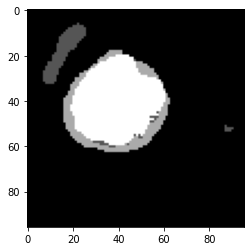

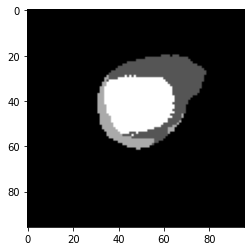

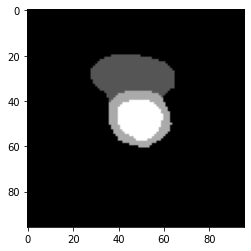

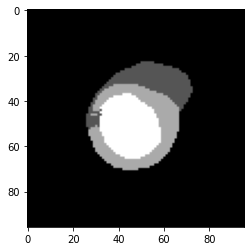

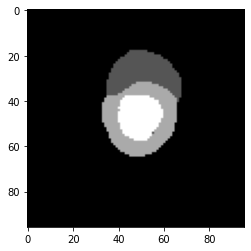

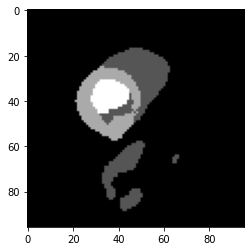

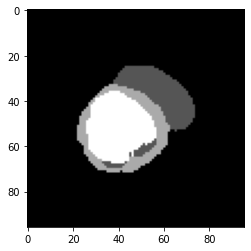

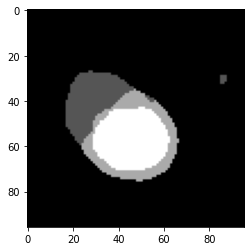

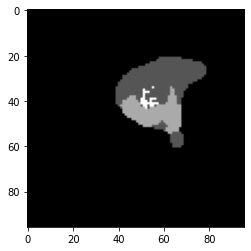

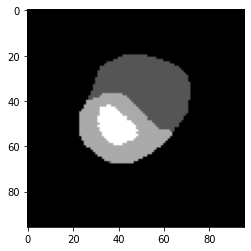

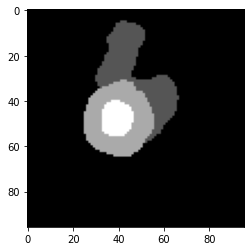

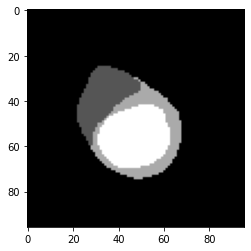

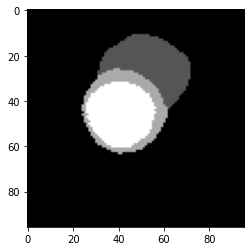

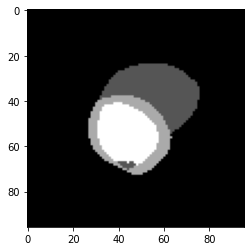

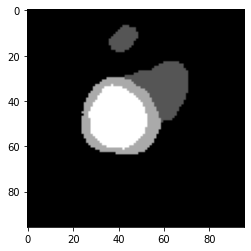

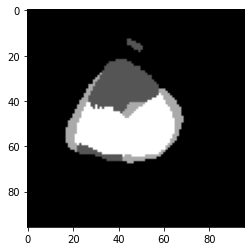

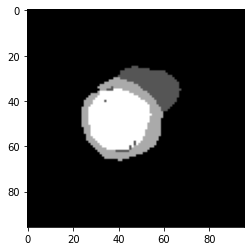

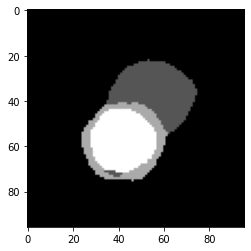

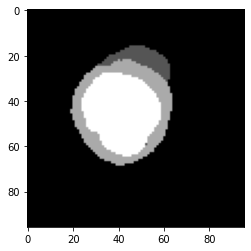

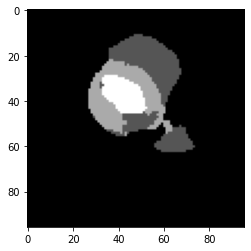

In [18]:
test_data_path = '/content/drive/My Drive/data/test'
test_set = TestDataset(test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=4, batch_size=batchsize, shuffle=False)
PATH = os.path.join(model_data_path,'Unet_align', 'Bestmodel_epoch_112'+'.pth')
net = UNet(num_classes = 4).cuda()
net.load_state_dict(torch.load(PATH))
net.eval()
val_loss = AverageMeter()
batchsize=4
learningrate=1e-5


# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learningrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


for iteration, sample in enumerate(test_data_loader):
    img= sample
    img=img.unsqueeze(1).cuda() # adding 1 channel
    #mask=mask.to(dtype=torch.int64).cuda()# mask should be long type

    outputs = net(img)
    predictions = outputs.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
    plt.imshow(predictions[0,...],cmap='gray')
    plt.pause(0.1)